# 0. Install and Import Dependencies

In [3]:
!pip list

Package                      Version
---------------------------- --------
absl-py                      1.4.0
asttokens                    2.2.1
astunparse                   1.6.3
backcall                     0.2.0
beautifulsoup4               4.12.2
cachetools                   5.3.0
certifi                      2023.5.7
charset-normalizer           3.1.0
colorama                     0.4.6
comm                         0.1.3
contourpy                    1.0.7
cycler                       0.11.0
debugpy                      1.6.7
decorator                    5.1.1
executing                    1.2.0
filelock                     3.12.0
flatbuffers                  23.5.9
fonttools                    4.39.4
gast                         0.4.0
gdown                        4.7.1
google-auth                  2.18.1
google-auth-oauthlib         0.4.6
google-pasta                 0.2.0
grpcio                       1.54.2
h5py                         3.8.0
idna                         3.4
imageio

You should consider upgrading via the 'c:\users\bryan bu\desktop\lip-reading\.virtualenv\scripts\python.exe -m pip install --upgrade pip' command.


In [4]:
!pip install opencv-python==4.7.0.72 matplotlib==3.7.1 imageio==2.28.1 gdown==4.7.1 tensorflow==2.10.1

You should consider upgrading via the 'c:\users\bryan bu\desktop\lip-reading\.virtualenv\scripts\python.exe -m pip install --upgrade pip' command.


In [5]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [6]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 0


In [7]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [8]:
import gdown

In [9]:
# url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
# output = 'data.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('data.zip')

In [10]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [11]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [12]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [13]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [14]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11], dtype=int64)>

In [15]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [16]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [17]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    print(type(alignments))
    print(alignments)
    
    return frames, alignments

In [18]:
def load_data_without_alignments(path: str, folder_number): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data',f'{folder_number}',f'{file_name}.mpg')
    # alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = tf.zeros([21,])
        
    return frames, alignments

In [19]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [20]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [21]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))
print(f"Test: {tf.zeros([21,])}, type: {type(tf.zeros([21,]))}")

<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor([ 2  9 14 39  2 12 21  5 39  1 20 39 12 39 19  9 24 39 14 15 23], shape=(21,), dtype=int64)
Test: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], type: <class 'tensorflow.python.framework.ops.EagerTensor'>


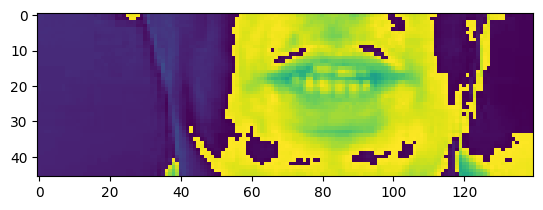

In [22]:
plt.imshow(frames[40])

In [23]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

In [24]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [25]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [26]:
from matplotlib import pyplot as plt

In [27]:
from PIL import Image
import numpy as np
img = np.zeros((1, 1, 1), dtype=np.float32)
img = np.array(img * 255, dtype=np.uint8)
img = np.squeeze(img, axis=2) # reduce dimension into (1, 1)
img = np.stack((img,) * 3, axis=-1) # convert grayscale to RGB
img = Image.fromarray(img)

In [28]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [29]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)
len(test)

50

In [30]:
frames, alignments = data.as_numpy_iterator().next()

<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[16 12  1  3  5 39  7 18  5  5 14 39 23  9 20  8 39 26 39 26  5 18 15 39
 16 12  5  1 19  5], shape=(30,), dtype=int64)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[12  1 25 39  2 12 21  5 39 23  9 20  8 39 25 39 14  9 14  5 39  1  7  1
  9 14], shape=(26,), dtype=int64)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor([ 2  9 14 39 23  8  9 20  5 39  1 20 39  7 39  6  9 22  5 39 19 15 15 14], shape=(24,), dtype=int64)


In [31]:
len(frames)

2

In [32]:
sample = data.as_numpy_iterator()

In [33]:
val = sample.next(); val[0]

<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[16 12  1  3  5 39  7 18  5  5 14 39  9 14 39  4 39 19  9 24 39 16 12  5
  1 19  5], shape=(27,), dtype=int64)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[16 12  1  3  5 39 23  8  9 20  5 39  2 25 39 24 39  5  9  7  8 20 39 14
 15 23], shape=(26,), dtype=int64)


array([[[[[ 1.2987053 ],
          [ 1.2987053 ],
          [ 1.4610435 ],
          ...,
          [ 0.20292272],
          [ 0.16233817],
          [ 0.16233817]],

         [[ 1.2987053 ],
          [ 1.2987053 ],
          [ 1.4610435 ],
          ...,
          [ 0.20292272],
          [ 0.16233817],
          [ 0.16233817]],

         [[ 1.4610435 ],
          [ 1.4610435 ],
          [ 1.420459  ],
          ...,
          [ 0.24350725],
          [ 0.16233817],
          [ 0.16233817]],

         ...,

         [[ 0.974029  ],
          [ 0.974029  ],
          [ 0.974029  ],
          ...,
          [10.308474  ],
          [10.308474  ],
          [10.308474  ]],

         [[ 0.9334445 ],
          [ 0.9334445 ],
          [ 0.9334445 ],
          ...,
          [10.308474  ],
          [10.308474  ],
          [10.308474  ]],

         [[ 0.9334445 ],
          [ 0.9334445 ],
          [ 0.9334445 ],
          ...,
          [10.308474  ],
          [10.308474  ],
          

In [34]:
from PIL import Image
import numpy as np

img = np.zeros((1, 1, 1), dtype=np.float32)
img = np.array(img * 255, dtype=np.uint8)
img = np.squeeze(img, axis=2) # reduce dimension into (1, 1)
img = np.stack((img,) * 3, axis=-1) # convert grayscale to RGB
img = Image.fromarray(img)

import imageio

imageio.mimsave('./animation.gif', [np.array(img)], duration=100)

<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor([12  1 25 39 18  5  4 39  1 20 39 11 39 19  5 22  5 14 39 19 15 15 14], shape=(23,), dtype=int64)


<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[16 12  1  3  5 39  7 18  5  5 14 39  9 14 39  4 39  6 15 21 18 39 14 15
 23], shape=(25,), dtype=int64)


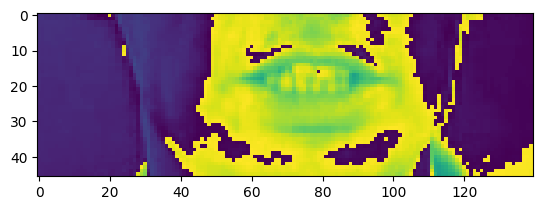

In [35]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][35])

In [36]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'place green in d six please'>

# 3. Design the Deep Neural Network

In [37]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [38]:
data.as_numpy_iterator().next()[0][0].shape

<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[16 12  1  3  5 39  2 12 21  5 39  1 20 39 16 39 26  5 18 15 39 16 12  5
  1 19  5], shape=(27,), dtype=int64)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor([16 12  1  3  5 39  7 18  5  5 14 39  9 14 39 17 39 20 23 15 39 14 15 23], shape=(24,), dtype=int64)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor([ 2  9 14 39 18  5  4 39 23  9 20  8 39 14 39 26  5 18 15 39 14 15 23], shape=(23,), dtype=int64)


(75, 46, 140, 1)

In [39]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [41]:
5*17*75

6375

In [42]:
yhat = model.predict(val[0])

1/1 [==============================] - 4s 4s/step


In [68]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin   bluue   at   f   twooo  nnooowww'>

In [69]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin   bluue   at   f   twooo  nnooowww'>

In [45]:
model.input_shape

(None, 75, 46, 140, 1)

In [46]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [47]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [48]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [49]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [50]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [51]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

In [52]:
schedule_callback = LearningRateScheduler(scheduler)

In [53]:
example_callback = ProduceExample(test)

In [54]:
# model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

# 5. Make a Prediction 

In [55]:
# url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
# output = 'checkpoints.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('checkpoints.zip', 'models')

In [56]:
model.load_weights('models/checkpoint')

In [57]:
test_data = test.as_numpy_iterator()

In [58]:
# sample = test_data.next()

In [59]:
# yhat = model.predict(sample[0])

In [60]:
# print('~'*100, 'REAL TEXT')
# [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

In [61]:
# decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [62]:
# print('~'*100, 'PREDICTIONS')
# [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

# Test on a Video

In [63]:
sample = load_data_without_alignments(tf.convert_to_tensor('.\\data\\s1\\bbaf2n.mpg'), "s1")
type(sample)
print(sample)

(<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
array([[[[1.4991664 ],
         [1.4991664 ],
         [1.4616872 ],
         ...,
         [0.41227075],
         [0.41227075],
         [0.41227075]],

        [[1.4991664 ],
         [1.4991664 ],
         [1.4616872 ],
         ...,
         [0.41227075],
         [0.41227075],
         [0.41227075]],

        [[1.4616872 ],
         [1.4616872 ],
         [1.4991664 ],
         ...,
         [0.33731243],
         [0.33731243],
         [0.33731243]],

        ...,

        [[1.0494164 ],
         [1.0494164 ],
         [1.0119373 ],
         ...,
         [0.11243747],
         [0.11243747],
         [0.07495832]],

        [[1.0494164 ],
         [1.0494164 ],
         [1.0119373 ],
         ...,
         [0.11243747],
         [0.07495832],
         [0.07495832]],

        [[1.0494164 ],
         [1.0494164 ],
         [1.0119373 ],
         ...,
         [0.07495832],
         [0.07495832],
         [0.03747916]]],


 

In [64]:
# print('~'*100, 'REAL TEXT')
# [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

In [65]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 2s 2s/step


In [66]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [67]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f two now'>]